# MLNT - Food-101

Implemention of MLNT over the Food-101 dataset

- 1. Google Colab Settings
- 2. MLNT
- 3. Manage relabel log file

The main difference with respect to the food implementation is that the dataloader has been modified in order to be able to record how the relabeling is done on each batch.

## 1. Google Colab Settings:

In [1]:
!pip install wandb

     |████████████████████████████████| 1.4MB 2.8MB/s 
     |████████████████████████████████| 102kB 7.9MB/s 
     |████████████████████████████████| 112kB 17.4MB/s 
     |████████████████████████████████| 102kB 7.9MB/s 
     |████████████████████████████████| 163kB 16.8MB/s 
     |████████████████████████████████| 71kB 6.7MB/s 
     |████████████████████████████████| 71kB 7.8MB/s 
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=25c67e4309885ce50ed7babc3fa8d79b427c4afe7a334f0a6435540bb7d989d5
  Stored in directory: /root/.cache/pip/wheels/ce/0e/7b/58a8a5268655b3ad74feef5aa97946f0addafb3cbb6bd2da23
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=4ee24a5787f3bcbbb1b2a6c5704fb3985827172b1b99218ee10126669e616bfb
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73870 sha256=1190

In [2]:
!wandb login

wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: dff003aa03e7d25df35a840b6f0660ae9675efb4
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [3]:

#GPU INFO
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jul 29 06:12:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [5]:
import sys
sys.path.append('/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/MLNT_Food101')

## 2. MLNT 

In [6]:
# Pytorch libraries
import torch
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

# Internal files
import config
import dataloader
import models
# from baseline import get_model, save_checkpoint

import math
import pandas
import os
import sys
import time
from collections import OrderedDict
import random

import wandb
import pandas
import numpy as np


noise file /content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/MLNT_Food101/data/noisy_label_kv50_sim.txt generated with noise: 0.5



In [7]:
import pandas as pd
import torchvision.transforms as transforms
from PIL import Image

def get_repr():

    transform_train = transforms.Compose([

        transforms.Resize(config.image_size),
        transforms.CenterCrop(config.image_size-config.crop),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),

    ])

    repr_imgs = []

    filename = config.drive_dir + '/data/' + 'representants_'+str(int(config.r*100))+'.csv'
    reps = pd.read_csv(filename, header = None, index_col = None, sep = " ")
    reps.columns = ["dir_0","dir", "class"]
    reps["dir"] = [ config.drive_dir + '/data/' + x[56:] for x in reps.dir]
    reps = reps[["dir","class"]]


    for i, row in reps.iterrows():
        print(row['dir'], row['class'])
        img_path = row['dir']
        image = Image.open(img_path).convert('RGB')
        img = transform_train(image)

        repr_imgs.append(img.unsqueeze(0))

    return torch.cat(repr_imgs)


In [ ]:
r = get_repr()
print(r.shape)

/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/MLNT_Food101/data/images/gyoza/2710456.jpg 0
/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/MLNT_Food101/data/images/takoyaki/3063506.jpg 1
/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/MLNT_Food101/data/images/escargots/3923582.jpg 2
/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/MLNT_Food101/data/images/apple_pie/2921600.jpg 3
/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/MLNT_Food101/data/images/samosa/3109188.jpg 4
/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/MLNT_Food101/data/images/huevos_rancheros/761257.jpg 5
/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/MLNT_Food101/data/images/caesar_salad/3592217.jpg 6
/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/MLNT_Food101/data/images/risotto/303964.jpg 7
/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/MLNT_Food101/data/images/panna_cotta/3571781.jpg 8
/content/d

In [ ]:
def get_model():

    # Get model from config
    if config.model == "resnet18":
        model = models.resnet18(pretrained=config.pretrained)
    elif config.model == "resnet34":
        model = models.resnet34(pretrained=config.pretrained)
    elif config.model == 'resnet50':
        model = models.resnet50(pretrained=config.pretrained)
    elif config.model == "resnet101":
        model = models.resnet101(pretrained=config.pretrained)
    elif config.model == "resnet152":
        model = models.resnet152(pretrained=config.pretrained)
    elif config.model == "resnext50_32x4d":
        model = models.resnet34(pretrained=config.pretrained)
    elif config.model == 'resnext101_32x8d':
        model = models.resnet50(pretrained=config.pretrained)
    elif config.model == "wide_resnet50_2":
        model = models.resnet101(pretrained=config.pretrained)
    elif config.model == "wide_resnet101_2":
        model = models.resnet152(pretrained=config.pretrained)
    else:
        raise ValueError('%s not supported'.format(config.model))

    # Initialize fc layer
    (in_features, out_features) = model.fc.in_features, model.fc.out_features
    model.fc = torch.nn.Linear(in_features, out_features)
    return model



def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if config.use_wandb == True:
        wandb.save(filename)

In [ ]:
def scheduler(epoch: int):
    global lr
    lr = config.lr
    if epoch > config.start_epoch:
        lr = lr / 10.0
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Training
def train(epoch):
    global init
    global df_relabel
    global df_dist
    global r
    net.train()
    tch_net.train()
    train_loss = 0
    correct = 0
    total = 0
    scheduler(epoch)


    _,feats_repr = pretrain_net(r.cuda(), get_feat=True)


    # ramp up meta-learning rate and EMA decay
    if epoch <= config.param_epoch:
        u = epoch/config.param_epoch
        meta_lr = config.meta_lr*math.exp(-5*(1-u)**2)
        lamb = 0.5*math.exp(-5*(1-u)**2)
    else:
        meta_lr = config.meta_lr
        config.eps = 0.999

    for step, (inputs, targets, path) in enumerate(train_loader):
        # print(step, inputs, targets, path)
        init_time = time.time()
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        outputs = net(inputs)

        class_loss = criterion(outputs, targets)
        class_loss.backward(retain_graph=True)


        if step > config.start_iter or epoch > 1:
        #if step > 0 or epoch > 0:

            # if step > config.mid_iter or epoch > 1:
            #     # config.eps = 0.999
            #     alpha = config.alpha
            # else:
            #     u = (step - config.start_iter)/(config.mid_iter - config.start_iter)
            #     alpha = config.alpha*math.exp(-5*(1-u)**2)
            alpha = config.alpha

            if init:
                init = False
                for param, param_tch in zip(net.parameters(), tch_net.parameters()):
                    param_tch.data.copy_(param.data)
            else:
                for param, param_tch in zip(net.parameters(), tch_net.parameters()):
                    param_tch.data.mul_(config.eps).add_((1-config.eps), param.data)

            _, feats = pretrain_net(inputs.cuda(), get_feat=True)
            tch_outputs = tch_net(inputs, get_feat=False)
            p_tch = F.softmax(tch_outputs, dim=1)
            p_tch.detach_()

            if use_mentor == True:
                mnt_outputs = mentor_net(inputs, get_feat=False)
                p_mnt = F.softmax(tch_outputs, dim=1)
                p_mnt.detach_()

            for i in range(config.num_fast):
                targets_fast = targets.clone()
                targets_fast2 = targets.clone()
                distances = []
                randidx = torch.randperm(targets.size(0))
                for n in range(int(targets.size(0)*config.perturb_ratio)):
                    num_neighbor = 0
                    idx = randidx[n]
                    feat = feats[idx]
                    # feat.view(1, feat.size(0))
                    # feat.data = feat.data.expand(targets.size(0), feat.size(0))
                    # print(feat.shape)
                    # print(feats_repr.shape)
                    dist = torch.sum((feat-feats_repr)**2, dim=1)
                    darray = dist.cpu().numpy()
                    # distances.append(np.amin(darray[darray!=0.]))
                    distances.append(np.amin(darray))
                    _, neighbor = torch.topk(dist.data, num_neighbor+1, largest=False)
                    targets_fast[idx] = neighbor #targets[neighbor[random.randint(1, num_neighbor)]]
                    targets_fast2[idx] = -1 #mark the incdices that have been relabeled

                #set a row of the dataframe
                # print(distances)
                
                new_row = {"batch":step, "fast_num":i, "dir":path,"noisy_labels":targets, "knn_labels":targets_fast, "resample_index":targets_fast2, "dist":distances}
                # print(new_row)
                df_relabel = df_relabel.append(new_row,ignore_index=True)
                # new_row = {"dist": distances}
                # df_dist = df_dist.append(new_row, ignore_index = True)


                # #xexport relabel track dataframe
                filename = config.drive_dir + '/data/' + 'relabeling_representants_'+str(int(config.r*100))+'.csv'
                df_relabel.to_csv(filename, sep=';', index=False,header = False)
                # filename = config.drive_dir + '/data/' + 'relabeling_distances_'+str(int(config.r*100))+'.csv'      
                # df_dist.to_csv(filename, sep=';', index=False,header = False)


                fast_loss = criterion(outputs, targets_fast)

                grads = torch.autograd.grad(fast_loss, net.parameters(),
                                            create_graph=False,
                                            retain_graph=True,
                                            only_inputs=True)

                fast_weights = OrderedDict(
                    (name, param - meta_lr*grad)
                    for ((name, param), grad) in zip(net.named_parameters(), grads))

                fast_out = net.forward(inputs,fast_weights)

                logp_fast = F.log_softmax(fast_out,dim=1)

                #afegir canvis per iterative aquí
                if use_mentor == False:
                    consistent_loss = consistent_criterion(logp_fast, p_tch)
                else:
                    consistent_loss = consistent_criterion(logp_fast, p_tch*lamb + p_mnt*(1-lamb))

                consistent_loss = consistent_loss*alpha/config.num_fast
                consistent_loss.backward()

        optimizer.step()

        # train_loss += class_loss.data.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        # Grab training results
        sys.stdout.write('\r')
        sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%, time: %.3f'
              %(epoch, config.num_epochs, step+1, (len(train_loader.dataset)//config.batch_size)+1, class_loss.data.item(), 100.*correct/total,time.time() - init_time))
        sys.stdout.flush()

        #xexport relabel track dataframe
        filename = config.drive_dir + '/data/' + 'relabeling_'+str(int(config.r*100))+'.csv'
        df_relabel.to_csv(filename, sep=';', index=False,header = False)


def valid(epoch, network):
    global best_acc
    network.eval()
    # val_loss = 0
    correct = 0
    total = 0
    for step, (inputs, targets, path) in enumerate(valid_loader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
            outputs = network(inputs)
            loss = criterion(outputs, targets)

        # valid_loss += loss.data.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        # Grab validation results
        valid_acc = 100. * correct / total
      # valid_results = ("| Epoch: {}/{}, val_loss: {:.3f}, val_acc: {:.3f}, "
      #                 "lr: {:.6f}".format(epoch,
      #                                     config.num_epochs,
      #                                     loss.data.item(),
      #                                     valid_acc,
      #                                     lr))
        # Grab validation results
        valid_results = ("| Epoch: {}/{}, val_loss: {:.3f}, val_acc: {:.3f}, ""lr: {:.6f}".format(epoch,config.num_epochs,loss.data.item(),valid_acc,lr))
        record.write(valid_results + '\n')
        record.flush()



    # Save checkpoint when best model
    if valid_acc > best_acc:
        best_acc = valid_acc
        print('| Saving Best Model ...', end="\r")
        save_point = config.drive_dir + '/checkpoint/' + config.id + '.pth.tar'
        save_checkpoint({
            'state_dict': network.state_dict(),
            'best_acc': best_acc,
        }, save_point)

    wandb.log({'epoch': epoch, 'accy_val' : best_acc })

    return valid_results


def test():
    test_net.eval()
    # test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets, path) in enumerate(valid_loader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
            outputs = test_net(inputs)
            loss = criterion(outputs, targets)

        # test_loss += loss.data.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    # Grab validation results
    test_acc = 100. * correct/total
    test_results = "| test_loss: {:.3f}, test_acc: {:.3f}".format(
        loss.data.item(), test_acc)
    record.write(test_results)
    record.flush()

    print(test_results)

In [ ]:
def save_weights(epoch):
        print('| Saving Weights student ...', end="\r")
        save_point = config.drive_dir + '/checkpoint/' + config.id + '_student_' + str(epoch) + '.pth.tar'
        save_checkpoint({'state_dict': net.state_dict(), }, save_point)

        print('| Saving Weights teacher ...', end="\r")
        save_point = config.drive_dir + '/checkpoint/' + config.id + '_teacher_' + str(epoch) + '.pth.tar'
        save_checkpoint({'state_dict': tch_net.state_dict(), }, save_point)

In [ ]:
# Checkpoint dir.
record = open(config.drive_dir + '/checkpoint/' + config.checkpoint + '_test.txt', 'w')
#ecord.write('noise_rate=%s\n' % config.noise_rate)
record.flush()

# Get the original_dataset
loader = dataloader.KeyDataLoader()
train_loader, valid_loader, test_loader = loader.run()

# Hyper Parameter settings
random.seed(config.seed)
# torch.cuda.set_device(config.gpuid)
torch.manual_seed(config.seed)
torch.cuda.manual_seed_all(config.seed)
use_cuda = torch.cuda.is_available()

# Networks setup
print('\nModel setup')
print('| Building network: {}'.format(config.model))
net = get_model()
tch_net = get_model()
pretrain_net = get_model()
test_net = get_model()

print('| load pretrained net. from checkpoint...')
checkpoint = torch.load(config.drive_dir + '/checkpoint/' + config.checkpoint + '.pth.tar')
pretrain_net.load_state_dict(checkpoint['state_dict'])

if use_cuda:
    net.cuda()
    tch_net.cuda()
    pretrain_net.cuda()
    test_net.cuda()
    cudnn.benchmark = True
pretrain_net.eval()

for param in tch_net.parameters():
    param.requires_grad = False
for param in pretrain_net.parameters():
    param.requires_grad = False

# Instantiate a loss function.
criterion = torch.nn.CrossEntropyLoss()
consistent_criterion = torch.nn.KLDivLoss()

# Instantiate an optimizer to train the model
optimizer = torch.optim.SGD(
    net.parameters(), lr=config.lr, momentum=config.momentum, weight_decay=config.weight_decay)

print('\nTraining model')
print('| Training Epochs = ' + str(config.num_epochs))
print('| Initial Learning Rate = ' + str(config.lr))
print('| Optimizer = ' + str(config.optimizer_type))




Model setup
| Building network: resnet50


/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/MLNT_Food101/models/resnet.py:116: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight, mode='fan_out')
/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/MLNT_Food101/models/resnet.py:118: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.weight, 1)
/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/MLNT_Food101/models/resnet.py:119: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



| load pretrained net. from checkpoint...

Training model
| Training Epochs = 5
| Initial Learning Rate = 0.008
| Optimizer = SGD


In [ ]:
def get_accy(loader):
    test_net.eval()
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(loader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
            outputs = test_net(inputs)
            loss = criterion(outputs, targets)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    # Grab results results
    test_acc = 100. * correct/total
    test_results = "| loss: {:.3f}, acc: {:.3f}".format(
        loss.data.item(), test_acc)

    print(test_results)

In [ ]:
# config.start_epoch = 10

In [ ]:
#initialize dataframer
import pandas as pd
df_relabel = pd.DataFrame(columns = ["batch", "fast_num", "dir", "noisy_labels", "knn_labels", "resample_index"])
# df_dist = pd.DataFrame(columns = ["dist"])


#set mentor parameter on the train funciton
use_mentor = False
init = True
best_acc = 0
for epoch in range(1, 2): #compute only one epoch
    train(epoch)
    # Student validation
    std_results = valid(epoch, net)
    record.write(std_results + '\n')
    print(std_results)
    # Teacher validation
    tch_results = valid(epoch, tch_net)
    record.write(tch_results + '\n')
    record.flush()
    print(tch_results)

    save_weights(epoch)

print('\nTesting model')
checkpoint = torch.load(config.drive_dir + '/checkpoint/%s.pth.tar' % config.id)
test_net.load_state_dict(checkpoint['state_dict'])
test()

| Epoch [  1/  5] Iter[501/1066]		Loss: 4.3304 Acc@1: 6.063%, time: 0.320

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2247: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


| Epoch [  1/  5] Iter[502/1066]		Loss: 4.5442 Acc@1: 6.069%, time: 6.854

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


| Epoch [  1/  5] Iter[970/1066]		Loss: 4.3853 Acc@1: 8.339%, time: 185.226

In [ ]:
df_relabel

In [ ]:
for i, (inputs, targets, path) in enumerate(train_loader):
    print(i)
    break

In [ ]:
inputs

In [ ]:
_,feats_repr = pretrain_net(r.cuda(), get_feat=True)

In [ ]:
_,feats = pretrain_net(inputs.cuda(), get_feat=True)
feat = feats[3]

In [ ]:
feat.shape

In [ ]:
feats_repr.shape

In [ ]:
torch.sum((feat-feats_repr)**2, dim=1)

In [ ]:
feats.shape

In [ ]:
feats_repr.shape

### 2.1 Continue the learning process
*Not always mandatory, only required when the cell below has crashed due to limited time of execution of a google colab session.*

Fill the last fully finished epoch:

In [ ]:
EPOCH = 14

Reload weights

In [ ]:
print('Load Student')
checkpoint = torch.load(config.drive_dir + '/checkpoint/' + config.id + '_student_' + str(EPOCH) + '.pth.tar' )
net.load_state_dict(checkpoint['state_dict'])

print('Load Teacher')
checkpoint = torch.load(config.drive_dir + '/checkpoint/' + config.id + '_teacher_' + str(EPOCH) + '.pth.tar' )
tch_net.load_state_dict(checkpoint['state_dict'])

# print('Load Mentor')
# checkpoint = torch.load(config.drive_dir + '/checkpoint/MLNT.pth.tar')
# mentor_net.load_state_dict(checkpoint['state_dict'])

Get accuracies on each dataset (not mandatory, good practice)

In [ ]:
print('\nTesting model')
checkpoint = torch.load(config.drive_dir + '/checkpoint/MLNT_discarding.pth.tar')
mentor_net.load_state_dict(checkpoint['state_dict'])
print('\n Validation Accy:')
get_accy(valid_loader)
print('\n Test Accy:')
get_accy(test_loader)
print('\n Train Accy:')
get_accy(train_loader)

Continue the learning process on the given epoch

In [ ]:
init = False
best_acc = 0
use_mentor = False
for epoch in range(EPOCH, EPOCH + 11):
    train(epoch)
    # Student validation
    std_results = valid(epoch, net)
    record.write(std_results + '\n')
    print(std_results)
    # Teacher validation
    tch_results = valid(epoch, tch_net)
    record.write(tch_results + '\n')
    record.flush()
    print(tch_results)

    save_weights(epoch)

print('\nTesting model')
checkpoint = torch.load(config.drive_dir + '/checkpoint/%s.pth.tar' % config.id)
test_net.load_state_dict(checkpoint['state_dict'])
test()

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2247: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


| Epoch: 14/60, val_loss: 0.833, val_acc: 74.231, lr: 0.000800
| Epoch: 14/60, val_loss: 0.613, val_acc: 76.686, lr: 0.000800
| Epoch [ 15/ 60] Iter[2131/2131]		Loss: 0.6046 Acc@1: 84.260%, time: 1.563| Epoch: 15/60, val_loss: 0.781, val_acc: 72.053, lr: 0.000800
| Epoch: 15/60, val_loss: 0.452, val_acc: 76.977, lr: 0.000800
| Epoch [ 16/ 60] Iter[1874/2131]		Loss: 0.6332 Acc@1: 84.957%, time: 2.965

### 2.2 Discarding

## 3. Manage relabel log file

In [ ]:
df_relabel

,batch,fast_num,dir,noisy_labels,knn_labels,resample_index,dist


In [8]:
config.r 

0.5

Read file (it has been generated doing train)

In [9]:
filename = config.drive_dir + '/data/' + 'relabeling_'+str(int(config.r*100))+'.csv'
df_learning = pandas.read_csv(filename, sep=';',header = None)
df_learning.columns = ["batch", "fast_num", "dir", "noisy_labels", "knn_labels", "resample_index","dist"]
df_learning

,batch,fast_num,dir,noisy_labels,knn_labels,resample_index,dist
0,501,0,('/content/drive/My Drive/Colab_Notebooks/git/...,"tensor([14, 86, 36, 10, 4, 97, 60, 60, 99, 32...","tensor([14, 86, 38, 10, 4, 97, 94, 60, 47, 32...","tensor([14, -1, -1, -1, 4, 97, -1, 60, -1, 32...","[273.38376, 207.90144, 292.64697, 133.90894, 2..."
1,501,1,('/content/drive/My Drive/Colab_Notebooks/git/...,"tensor([14, 86, 36, 10, 4, 97, 60, 60, 99, 32...","tensor([14, 86, 36, 10, 4, 97, 94, 60, 47, 32...","tensor([14, 86, 36, -1, 4, 97, -1, 60, -1, -1...","[264.87823, 148.4365, 214.53076, 273.38376, 20..."
2,501,2,('/content/drive/My Drive/Colab_Notebooks/git/...,"tensor([14, 86, 36, 10, 4, 97, 60, 60, 99, 32...","tensor([14, 86, 38, 10, 4, 97, 94, 60, 99, 32...","tensor([-1, 86, -1, -1, 4, -1, -1, 60, 99, 32...","[243.03471, 208.49158, 190.17537, 317.02856, 2..."
3,501,3,('/content/drive/My Drive/Colab_Notebooks/git/...,"tensor([14, 86, 36, 10, 4, 97, 60, 60, 99, 32...","tensor([14, 86, 36, 10, 4, 97, 94, 60, 99, 32...","tensor([-1, 86, 36, -1, 4, 97, -1, 60, 99, 32...","[148.4365, 214.53076, 320.5829, 264.87823, 97...."
4,501,4,('/content/drive/My Drive/Colab_Notebooks/git/...,"tensor([14, 86, 36, 10, 4, 97, 60, 60, 99, 32...","tensor([14, 86, 36, 10, 44, 97, 94, 18, 47, 32...","tensor([-1, 86, 36, -1, -1, -1, -1, -1, -1, -1...","[244.95844, 236.08716, 153.1456, 190.17537, 31..."
...,...,...,...,...,...,...,...
1965,697,5,('/content/drive/My Drive/Colab_Notebooks/git/...,"tensor([84, 53, 80, 39, 68, 60, 94, 59, 4, 45...","tensor([ 84, 53, 43, 76, 68, 60, 94, 71...","tensor([-1, 53, -1, -1, 68, -1, 94, -1, -1, 45...","[246.16556, 260.883, 309.83655, 265.30667, 205..."
1966,697,6,('/content/drive/My Drive/Colab_Notebooks/git/...,"tensor([84, 53, 80, 39, 68, 60, 94, 59, 4, 45...","tensor([84, 53, 43, 76, 68, 60, 94, 71, 4, 45...","tensor([84, -1, -1, -1, 68, 60, -1, -1, 4, -1...","[159.52112, 301.33908, 260.883, 222.57251, 222..."
1967,697,7,('/content/drive/My Drive/Colab_Notebooks/git/...,"tensor([84, 53, 80, 39, 68, 60, 94, 59, 4, 45...","tensor([ 84, 53, 43, 39, 68, 60, 94, 71...","tensor([-1, 53, -1, 39, 68, 60, -1, -1, 4, 45...","[186.94632, 269.07608, 301.33908, 222.20229, 1..."
1968,697,8,('/content/drive/My Drive/Colab_Notebooks/git/...,"tensor([84, 53, 80, 39, 68, 60, 94, 59, 4, 45...","tensor([84, 53, 43, 76, 68, 60, 94, 71, 4, 45...","tensor([-1, -1, -1, -1, 68, -1, 94, -1, 4, 45...","[271.6962, 289.5456, 232.90665, 222.57852, 304..."


In [10]:
filename

'/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/MLNT_Food101/data/relabeling_50.csv'

In [11]:
df_learning.dist[0]

'[273.38376, 207.90144, 292.64697, 133.90894, 216.68433, 317.02856, 271.77695, 304.8408, 229.52069, 208.49158, 197.47433, 244.95844, 153.1456, 321.30713, 320.5829, 172.3769, 229.16647, 190.17537, 164.09494, 185.62646, 263.7182, 237.83105, 178.41515, 218.08759, 235.92107, 234.22523, 205.87193, 214.53076, 202.14577, 267.70197, 189.3928, 193.25981]'

Some cleaning/processing

In [12]:
df_expl = pandas.DataFrame()

for index, row in df_learning.iterrows():
  
  # print(index)
  df_aux = pandas.DataFrame()

  df_aux["dir"] = df_learning.dir[index].replace("(", "").replace(")","").replace("'","").split(",")
  df_aux["noisy_labels"] = df_learning.noisy_labels[index].split('[', 1)[1].split(']')[0].replace("(", "").replace(")","").replace("'","").replace(" ","").replace("\n","").split(",")
  df_aux["knn_labels"] = df_learning.knn_labels[index].split('[', 1)[1].split(']')[0].replace("(", "").replace(")","").replace("'","").replace(" ","").replace("\n","").split(",")
  df_aux["knn_lresample_indexabels"] = df_learning.resample_index[index].split('[', 1)[1].split(']')[0].replace("(", "").replace(")","").replace("'","").replace(" ","").replace("\n","").split(",")
  df_aux["batch"] = [df_learning.batch[index]]*df_aux.shape[0]
  df_aux["fast_num"] = [df_learning.fast_num[index]]*df_aux.shape[0]

  df_expl = df_expl.append(df_aux.copy(), ignore_index=True)
df_expl

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num
0,/content/drive/My Drive/Colab_Notebooks/git/PF...,14,14,14,501,0
1,/content/drive/My Drive/Colab_Notebooks/git/P...,86,86,-1,501,0
2,/content/drive/My Drive/Colab_Notebooks/git/P...,36,38,-1,501,0
3,/content/drive/My Drive/Colab_Notebooks/git/P...,10,10,-1,501,0
4,/content/drive/My Drive/Colab_Notebooks/git/P...,4,4,4,501,0
...,...,...,...,...,...,...
126075,/content/drive/My Drive/Colab_Notebooks/git/P...,77,77,77,697,9
126076,/content/drive/My Drive/Colab_Notebooks/git/P...,39,28,-1,697,9
126077,/content/drive/My Drive/Colab_Notebooks/git/P...,27,27,27,697,9
126078,/content/drive/My Drive/Colab_Notebooks/git/P...,10,72,-1,697,9


In [13]:
df_expl["dir"] = [x.split("/")[-2] + "/" +x.split("/")[-1] for x in df_expl.dir]

In [14]:
def pos(n):
  if int(n)>=0:
    return(0)
  return(-1)
  
df_expl["knn_lresample_indexabels"] = [pos(x) for x in df_expl.knn_lresample_indexabels]

In [15]:
df_expl

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num
0,chicken_quesadilla/3746652.jpg,14,14,0,501,0
1,creme_brulee/66315.jpg,86,86,-1,501,0
2,lobster_bisque/2306644.jpg,36,38,-1,501,0
3,spaghetti_bolognese/2329553.jpg,10,10,-1,501,0
4,prime_rib/2533638.jpg,4,4,0,501,0
...,...,...,...,...,...,...
126075,cup_cakes/3429805.jpg,77,77,0,697,9
126076,ceviche/882382.jpg,39,28,-1,697,9
126077,onion_rings/892346.jpg,27,27,0,697,9
126078,falafel/2073253.jpg,10,72,-1,697,9


Export processed file

In [16]:
  filename = config.drive_dir + '/data/' + 'relabeling_'+str(int(config.r*100))+'_processed.csv'
  df_expl.to_csv(filename, sep=';', index=False,header = False)

In [17]:
df_expl

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num
0,chicken_quesadilla/3746652.jpg,14,14,0,501,0
1,creme_brulee/66315.jpg,86,86,-1,501,0
2,lobster_bisque/2306644.jpg,36,38,-1,501,0
3,spaghetti_bolognese/2329553.jpg,10,10,-1,501,0
4,prime_rib/2533638.jpg,4,4,0,501,0
...,...,...,...,...,...,...
126075,cup_cakes/3429805.jpg,77,77,0,697,9
126076,ceviche/882382.jpg,39,28,-1,697,9
126077,onion_rings/892346.jpg,27,27,0,697,9
126078,falafel/2073253.jpg,10,72,-1,697,9


Read again

In [18]:
filename = config.drive_dir + '/data/' + 'relabeling_'+str(int(config.r*100))+'_processed.csv'
df_expl = pandas.read_csv(filename, sep=';',header = None)
df_expl.columns = ["dir", "noisy_labels", "knn_labels", "knn_lresample_indexabels", "batch", "fast_num"]
df_expl

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num
0,chicken_quesadilla/3746652.jpg,14,14,0,501,0
1,creme_brulee/66315.jpg,86,86,-1,501,0
2,lobster_bisque/2306644.jpg,36,38,-1,501,0
3,spaghetti_bolognese/2329553.jpg,10,10,-1,501,0
4,prime_rib/2533638.jpg,4,4,0,501,0
...,...,...,...,...,...,...
126075,cup_cakes/3429805.jpg,77,77,0,697,9
126076,ceviche/882382.jpg,39,28,-1,697,9
126077,onion_rings/892346.jpg,27,27,0,697,9
126078,falafel/2073253.jpg,10,72,-1,697,9


Map clean labels

In [19]:
filename = config.drive_dir + '/data/' + 'clean_label_kv.txt'
df_kv = pandas.read_csv(filename, sep=' ',header = None)
df_kv.columns = ["dir","original label"]
df_kv["dir"] = [x.split("/")[-2] + "/" +x.split("/")[-1] for x in df_kv.dir]

In [20]:
df_kv = df_kv.set_index("dir")
mapping_dict = df_kv.to_dict()['original label']
df_expl["original_label"] = [mapping_dict[x] for x in df_expl.dir]
df_expl

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num,original_label
0,chicken_quesadilla/3746652.jpg,14,14,0,501,0,14
1,creme_brulee/66315.jpg,86,86,-1,501,0,86
2,lobster_bisque/2306644.jpg,36,38,-1,501,0,66
3,spaghetti_bolognese/2329553.jpg,10,10,-1,501,0,10
4,prime_rib/2533638.jpg,4,4,0,501,0,44
...,...,...,...,...,...,...,...
126075,cup_cakes/3429805.jpg,77,77,0,697,9,55
126076,ceviche/882382.jpg,39,28,-1,697,9,100
126077,onion_rings/892346.jpg,27,27,0,697,9,67
126078,falafel/2073253.jpg,10,72,-1,697,9,72


In [21]:
df_expl

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num,original_label
0,chicken_quesadilla/3746652.jpg,14,14,0,501,0,14
1,creme_brulee/66315.jpg,86,86,-1,501,0,86
2,lobster_bisque/2306644.jpg,36,38,-1,501,0,66
3,spaghetti_bolognese/2329553.jpg,10,10,-1,501,0,10
4,prime_rib/2533638.jpg,4,4,0,501,0,44
...,...,...,...,...,...,...,...
126075,cup_cakes/3429805.jpg,77,77,0,697,9,55
126076,ceviche/882382.jpg,39,28,-1,697,9,100
126077,onion_rings/892346.jpg,27,27,0,697,9,67
126078,falafel/2073253.jpg,10,72,-1,697,9,72


Filter the entries that have been relabeled

In [22]:
df_resamples = df_expl[df_expl.knn_lresample_indexabels == -1]
df_resamples

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num,original_label
1,creme_brulee/66315.jpg,86,86,-1,501,0,86
2,lobster_bisque/2306644.jpg,36,38,-1,501,0,66
3,spaghetti_bolognese/2329553.jpg,10,10,-1,501,0,10
6,cheesecake/918354.jpg,60,94,-1,501,0,60
8,peking_duck/818947.jpg,99,47,-1,501,0,81
...,...,...,...,...,...,...,...
126071,guacamole/2995635.jpg,35,28,-1,697,9,25
126072,filet_mignon/80047.jpg,76,36,-1,697,9,62
126076,ceviche/882382.jpg,39,28,-1,697,9,100
126078,falafel/2073253.jpg,10,72,-1,697,9,72


### Manage Distances

In [23]:
dist_list = [float(x) for y in df_learning.dist for x in y.replace("[","").replace("]","").split(",") ]
df_resamples["distances"] = dist_list.copy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
df_resamples

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num,original_label,distances
1,creme_brulee/66315.jpg,86,86,-1,501,0,86,273.38376
2,lobster_bisque/2306644.jpg,36,38,-1,501,0,66,207.90144
3,spaghetti_bolognese/2329553.jpg,10,10,-1,501,0,10,292.64697
6,cheesecake/918354.jpg,60,94,-1,501,0,60,133.90894
8,peking_duck/818947.jpg,99,47,-1,501,0,81,216.68433
...,...,...,...,...,...,...,...,...
126071,guacamole/2995635.jpg,35,28,-1,697,9,25,265.76697
126072,filet_mignon/80047.jpg,76,36,-1,697,9,62,228.14133
126076,ceviche/882382.jpg,39,28,-1,697,9,100,154.36116
126078,falafel/2073253.jpg,10,72,-1,697,9,72,415.20710


In [25]:
  filename = config.drive_dir + '/data/' + 'relabeling_distances_'+str(int(config.r*100))+'_processed.csv'
  df_resamples.to_csv(filename, sep=';', index=False,header = False)

In [26]:
df_resamples[df_resamples.noisy_labels == df_resamples.knn_labels].shape[0]/df_resamples.shape[0]

0.3140704314720812

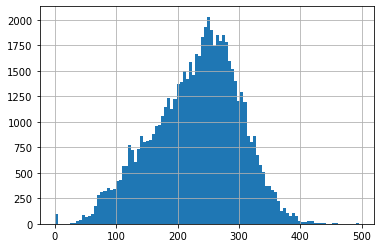

In [27]:
df_resamples.distances.hist(bins = 100)

In [35]:
np.quantile(df_resamples["distances"], 0.25)

183.41942

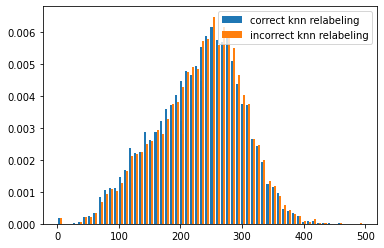

In [28]:
import numpy as np
import matplotlib.pyplot as plt

a = df_resamples[df_resamples.knn_labels == df_resamples.original_label ].distances
b = df_resamples[df_resamples.knn_labels != df_resamples.original_label ].distances

plt.hist([a, b], bins = 60, density = True, label=['correct knn relabeling', 'incorrect knn relabeling'])
plt.legend(loc='upper right')
plt.show()

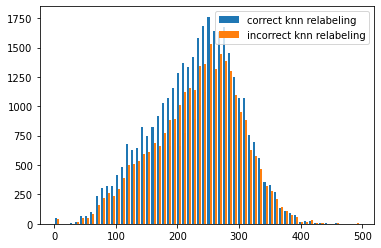

In [29]:
import numpy as np
import matplotlib.pyplot as plt

a = df_resamples[df_resamples.knn_labels == df_resamples.original_label ].distances
b = df_resamples[df_resamples.knn_labels != df_resamples.original_label ].distances

plt.hist([a, b], bins = 60, density = False, label=['correct knn relabeling', 'incorrect knn relabeling'])
plt.legend(loc='upper right')
plt.show()

In [30]:
### Manage Distances

### Distances on correct labels spoiled

In [36]:
def get_correct_labels_spoiled(df, tau):
  df_clean_relabeled =  df[(df.noisy_labels == df.original_label) & (df.distances < tau)]
  df_clean_missrelabeled = df_clean_relabeled[df_clean_relabeled.knn_labels != df_clean_relabeled.original_label]
  try: 
    return(round(df_clean_missrelabeled.shape[0]*100/df_clean_relabeled.shape[0],2))
  except:
    return(0)

In [41]:
get_correct_labels_spoiled(df_resamples,500)

38.82

In [42]:
get_correct_labels_spoiled(df_resamples,183.41942)

37.03

In [43]:
corr_labels = get_correct_labels_spoiled(df_resamples,60)

In [44]:
corr_labels_spoiled = [get_correct_labels_spoiled(df_resamples,x) for x in range(0,1000,10)]


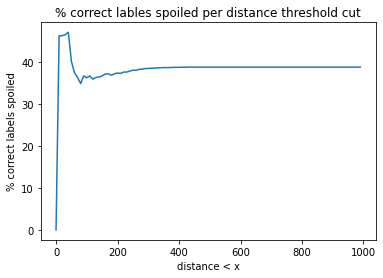

In [45]:
import matplotlib.pyplot as plt

plt.plot(range(0,1000,10),corr_labels_spoiled)
plt.title('% correct lables spoiled per distance threshold cut')
plt.xlabel('distance < x')
plt.ylabel('% correct labels spoiled')
plt.show()

In [46]:
def get_wrong_labels_corrected(df, tau):

  df_noisy_relabeled = df_resamples[(df_resamples.noisy_labels != df_resamples.original_label) & (df.distances < tau)] #filter noisy lables

  df_noisy_okrelabeled= df_noisy_relabeled[df_noisy_relabeled.knn_labels == df_noisy_relabeled.original_label]

  try: 
    return(round(df_noisy_okrelabeled.shape[0]*100/df_noisy_relabeled.shape[0],2))
  except:
    return(0)

In [47]:
get_wrong_labels_corrected(df_resamples,2000)

48.49

In [48]:
wrong_labels_corrected = [get_wrong_labels_corrected(df_resamples,x) for x in range(0,1000,10)]

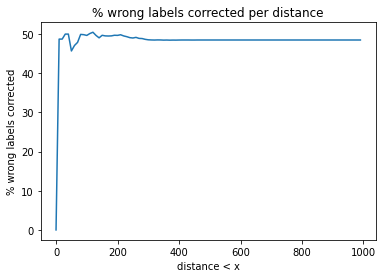

In [49]:
import matplotlib.pyplot as plt

plt.plot(range(0,1000,10),wrong_labels_corrected)
plt.title('% wrong labels corrected per distance')
plt.xlabel('distance < x')
plt.ylabel('% wrong labels corrected')
plt.show()

In [50]:
get_wrong_labels_corrected(df_resamples,2000)

48.49

### Correct Labels Spoiled(%)

In [51]:
df_clean_relabeled = df_resamples[df_resamples.noisy_labels == df_resamples.original_label] #filter clean lables
df_clean_relabeled

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num,original_label,distances
1,creme_brulee/66315.jpg,86,86,-1,501,0,86,273.38376
3,spaghetti_bolognese/2329553.jpg,10,10,-1,501,0,10,292.64697
6,cheesecake/918354.jpg,60,94,-1,501,0,60,133.90894
10,fish_and_chips/3718806.jpg,93,93,-1,501,0,93,317.02856
14,croque_madame/2897133.jpg,52,52,-1,501,0,52,304.84080
...,...,...,...,...,...,...,...,...
126055,beet_salad/2769513.jpg,17,73,-1,697,9,17,270.15503
126056,hamburger/883801.jpg,41,67,-1,697,9,41,232.90665
126060,pork_chop/3278808.jpg,36,36,-1,697,9,36,320.07935
126061,onion_rings/415945.jpg,67,67,-1,697,9,67,222.57251


In [52]:
df_clean = df_resamples[df_resamples.noisy_labels == df_resamples.original_label]
df_clean

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num,original_label,distances
1,creme_brulee/66315.jpg,86,86,-1,501,0,86,273.38376
3,spaghetti_bolognese/2329553.jpg,10,10,-1,501,0,10,292.64697
6,cheesecake/918354.jpg,60,94,-1,501,0,60,133.90894
10,fish_and_chips/3718806.jpg,93,93,-1,501,0,93,317.02856
14,croque_madame/2897133.jpg,52,52,-1,501,0,52,304.84080
...,...,...,...,...,...,...,...,...
126055,beet_salad/2769513.jpg,17,73,-1,697,9,17,270.15503
126056,hamburger/883801.jpg,41,67,-1,697,9,41,232.90665
126060,pork_chop/3278808.jpg,36,36,-1,697,9,36,320.07935
126061,onion_rings/415945.jpg,67,67,-1,697,9,67,222.57251


In [53]:
df_clean_missrelabeled = df_clean_relabeled[df_clean_relabeled.knn_labels != df_clean_relabeled.original_label]

In [54]:
df_clean_missrelabeled

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num,original_label,distances
6,cheesecake/918354.jpg,60,94,-1,501,0,60,133.90894
15,ravioli/1653704.jpg,95,0,-1,501,0,95,229.52069
27,sashimi/186955.jpg,87,43,-1,501,0,87,172.37690
52,chicken_wings/3912461.jpg,46,47,-1,501,0,46,205.87193
55,tuna_tartare/2066866.jpg,48,73,-1,501,0,48,202.14577
...,...,...,...,...,...,...,...,...
126002,sushi/3228675.jpg,49,38,-1,697,8,49,272.17703
126027,waffles/2403939.jpg,85,3,-1,697,9,85,152.47318
126033,creme_brulee/596459.jpg,86,38,-1,697,9,86,159.52112
126055,beet_salad/2769513.jpg,17,73,-1,697,9,17,270.15503


In [55]:
round(df_clean_missrelabeled.shape[0]*100/df_clean.shape[0],2)

38.82

In [56]:
config.r

0.5

In [57]:
df_learning.dist[0]

'[273.38376, 207.90144, 292.64697, 133.90894, 216.68433, 317.02856, 271.77695, 304.8408, 229.52069, 208.49158, 197.47433, 244.95844, 153.1456, 321.30713, 320.5829, 172.3769, 229.16647, 190.17537, 164.09494, 185.62646, 263.7182, 237.83105, 178.41515, 218.08759, 235.92107, 234.22523, 205.87193, 214.53076, 202.14577, 267.70197, 189.3928, 193.25981]'

### Wrong Labels Corrected (%)

In [58]:
df_noisy_relabeled = df_resamples[df_resamples.noisy_labels != df_resamples.original_label] #filter noisy lables
df_noisy_relabeled

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num,original_label,distances
2,lobster_bisque/2306644.jpg,36,38,-1,501,0,66,207.90144
8,peking_duck/818947.jpg,99,47,-1,501,0,81,216.68433
11,bread_pudding/1315854.jpg,1,3,-1,501,0,82,271.77695
16,cannoli/3293693.jpg,89,71,-1,501,0,71,208.49158
20,nachos/1777036.jpg,23,80,-1,501,0,28,197.47433
...,...,...,...,...,...,...,...,...
126070,caprese_salad/2688760.jpg,32,78,-1,697,9,78,296.40225
126071,guacamole/2995635.jpg,35,28,-1,697,9,25,265.76697
126072,filet_mignon/80047.jpg,76,36,-1,697,9,62,228.14133
126076,ceviche/882382.jpg,39,28,-1,697,9,100,154.36116


In [59]:
df_noisy = df_resamples[df_resamples.noisy_labels != df_resamples.original_label]
df_noisy

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num,original_label,distances
2,lobster_bisque/2306644.jpg,36,38,-1,501,0,66,207.90144
8,peking_duck/818947.jpg,99,47,-1,501,0,81,216.68433
11,bread_pudding/1315854.jpg,1,3,-1,501,0,82,271.77695
16,cannoli/3293693.jpg,89,71,-1,501,0,71,208.49158
20,nachos/1777036.jpg,23,80,-1,501,0,28,197.47433
...,...,...,...,...,...,...,...,...
126070,caprese_salad/2688760.jpg,32,78,-1,697,9,78,296.40225
126071,guacamole/2995635.jpg,35,28,-1,697,9,25,265.76697
126072,filet_mignon/80047.jpg,76,36,-1,697,9,62,228.14133
126076,ceviche/882382.jpg,39,28,-1,697,9,100,154.36116


In [60]:
df_noisy_okrelabeled= df_noisy_relabeled[df_noisy_relabeled.knn_labels == df_noisy_relabeled.original_label]

In [61]:
round(df_noisy_okrelabeled.shape[0]*100/df_noisy.shape[0],2)

48.49

## Get Correct Relabelings per Image

In [62]:
df_resamples

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num,original_label,distances
1,creme_brulee/66315.jpg,86,86,-1,501,0,86,273.38376
2,lobster_bisque/2306644.jpg,36,38,-1,501,0,66,207.90144
3,spaghetti_bolognese/2329553.jpg,10,10,-1,501,0,10,292.64697
6,cheesecake/918354.jpg,60,94,-1,501,0,60,133.90894
8,peking_duck/818947.jpg,99,47,-1,501,0,81,216.68433
...,...,...,...,...,...,...,...,...
126071,guacamole/2995635.jpg,35,28,-1,697,9,25,265.76697
126072,filet_mignon/80047.jpg,76,36,-1,697,9,62,228.14133
126076,ceviche/882382.jpg,39,28,-1,697,9,100,154.36116
126078,falafel/2073253.jpg,10,72,-1,697,9,72,415.20710


In [63]:
def correct_relabelin(original_label, knn_labels0):
  if (knn_labels == original_label):
    return(1)
  return(0)

In [64]:
df_resamples.knn_labels = df_resamples.original_label

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [65]:
correct_resampling = df_resamples.knn_labels == df_resamples.original_label
df_resamples["correct_resampling"] = [int(x) for x in correct_resampling]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [66]:
df_image_resampling_total = df_resamples[["dir", "correct_resampling"]]

In [67]:
df_image_resampling_total = df_image_resampling_total.groupby(["dir"]).sum()
df_image_resampling_total = df_image_resampling_total.sort_values(by = "correct_resampling", ascending = False)
df_image_resampling_total

,correct_resampling
dir,
spaghetti_bolognese/1978881.jpg,10
baklava/67320.jpg,10
macarons/915626.jpg,10
steak/979110.jpg,10
escargots/2250624.jpg,10
...,...
spaghetti_carbonara/2379305.jpg,1
garlic_bread/277854.jpg,1
dumplings/2840294.jpg,1


In [68]:
  filename = config.drive_dir + '/data/' + 'relabeling_'+str(int(config.r*100))+'_processed_images.csv'
  df_image_resampling_total.to_csv(filename, sep=';', index=True,header = False)

In [69]:
filename

'/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/MLNT_Food101/data/relabeling_50_processed_images.csv'

In [70]:
config.r

0.5